In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy as scp
import sklearn.neighbors
import time
from data_utils import load_dataset

# test

Below are the 3 regression datasets

In [2]:
x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('mauna_loa')

In [ ]:
x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('rosenbrock', n_train=1000, d=2)

In [ ]:
x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('pumadyn32nm')

Below are the 2 classification datasets

In [ ]:
x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('iris')

In [ ]:
x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('mnist_small')

Below is me understanding how the datasets work...

In [ ]:
print("x_test shape: {}\n".format(x_test.shape))
print(x_test)

In [ ]:
print("y_test shape: {}\n".format(y_test.shape))
print(y_test)

In [ ]:
x = x_test[0]
a = np.abs(x_train-x)
s = np.sum(a,axis=1).reshape((a.shape[0],-1))
partition = np.argpartition(s,kth=3,axis=0)
kNN = partition[:3]

print("x_train shape: {}".format(x_train.shape))
print("x_test point shape: {}".format(x.shape))
print("abs diff shape: {}".format(a.shape))
print("sum shape: {}\n".format(s.shape))

print("x_train:\n",x_train)
print("x_test point:",x)
print("abs diff:\n",a)
print("sum:\n",s)
print("3 kNN indices:\n",kNN)
print("3 kNN values:\n", s[kNN,0])

In [ ]:
x = x_test[0].reshape((1,-1))
a = np.abs(x_train-x)
s = np.sum(a,axis=1).reshape((a.shape[0],-1))
partition = np.argpartition(s,kth=3,axis=0)
kNN = partition[:3]

print("x_train shape: {}".format(x_train.shape))
print("x_test point shape: {}".format(x.shape))
print("abs diff shape: {}".format(a.shape))
print("sum shape: {}\n".format(s.shape))

print("x_train:\n",x_train)
print("x_test point:",x)
print("abs diff:\n",a)
print("sum:\n",s)
print("3 kNN indices:\n",kNN)
print("3 kNN values:\n", s[kNN,0])

Below is an implementation of the kNN algorithm for regression.

In [3]:
# first, implement distance metric as separate function
def minkowski_dists(x_train, x_test_i, l=2):
    
    """
    Returns Minkowski distance between each element
    of x_train and x_test_i as a (D,1) np array
    
    x_train is a (D,n) array
    x_test_i is a (n,) array
    
    dists is a (D,1) array
    """
    
    p = l
    x_test_i = x_test_i.reshape((1,-1)) # converts x_test_i to a (1,n) array
    # not necessary... will still work w/out this b/c broadcasting
    diff = np.abs(x_train-x_test_i)
    power = np.power(diff,p)
    sigma = np.sum(power,axis=1).reshape((x_train.shape[0],-1)) # axis = 1 --> sum along rows
    dists = np.power(sigma,1/p)
    return dists
    

In [4]:
def kNN_regress(x_train, y_train, x_test, k=1, l=2):
    
    """
    Returns y_test results corresponding to x_test inputs using kNN algorithm
    
    x_train is a (D,n) array
    y_train is a (D,1) array (regression: single output)
    x_test is a (T,n) array
    
    y_test is a (T,1) array (regression: single output)
    """
    
    num_test_points = x_test.shape[0]
    y_test = np.empty((num_test_points,1),)
    
    # compute distances (for each test point)
    # assume distance metric is the Minkowski distance
    for i, x_test_i in enumerate(x_test):
        dists = minkowski_dists(x_train, x_test_i,l)
        partition = np.argpartition(dists,kth=k,axis=0) # returns indices of dists
                                                        # axis = 0 --> partition along column
        kNN = partition[:k]
        y_test[i,0] = np.average(y_train[kNN,0])
    
    return y_test
    

Testing regression algorithm:

In [ ]:
print(x_train.shape)
print(x_train)

In [ ]:
print(x_test[0])

In [ ]:
# test minkowski function
x_test_i = x_test[0]
dists_one = minkowski_dists(x_train,x_test_i,l=1)
dists_two = minkowski_dists(x_train,x_test_i,l=2)
print(dists_one.shape)
print(dists_two.shape)
print("l=1:",dists_one)
print("l=2:",dists_two)
print(dists_one - dists_two)

In [ ]:
# test kNN function
k = 3
y_test_one = kNN_regress(x_train, y_train, x_test, k, l=1)
y_test_two = kNN_regress(x_train, y_train, x_test, k, l=2)

print(y_test_one)
print("\n\n\n")
print(y_test_two)
print("\n\n\n")
print(y_test_one - y_test_two)

Implementation of v-fold cross-validation with v = 5:

In [5]:
def v_fold_cross_validation_RMSE(x_train, y_train, N, k=1, max_l=2, v=5, testing=False):
    
    """
    Conducts cross validation on x_train and y_train with v folds
    
    x_train and y_train are (N,n) arrays
    trains using kNN validation with k
    repeats model with different minkowski distance metric with p up to max_l
    
    Returns the average RMSE across the folds and for each p up to max_l
    RMSE_avg is a (1,max_l) array
    """
    
    # divide data into v equal folds
    # split data into folds (by index)
    idx = np.arange(N,dtype=int)
    if (N%v != 0):
        # as N is not be a perfect multiple of v, add in 'fake' numbers that will be cleaned later
        extra = np.random.choice(idx, size=N%v, replace=False)
        idx = np.delete(idx,extra)
        idx = np.random.permutation(idx).reshape((v,-1))
        temp = -1 * np.ones(idx.shape[0], dtype=int)
        temp[:extra.shape[0]] = extra
        temp = temp.reshape(idx.shape[0],1)
        idx = np.hstack((idx,temp))
    else:
        idx = np.random.permutation(idx).reshape((v,-1))
    
    RMSE = np.empty((v,max_l))
    
    # train and test for each fold
    for i in range(v):
        ith_fold_idx = idx[i]
        ith_fold_idx = [i for i in ith_fold_idx if i>=0]
        training_idx = np.delete(idx, i, axis=0)
        training_idx = training_idx.reshape(-1) # flatten the array
        training_idx = [i for i in training_idx if i>=0]
        
        x_tr, y_tr = x_train[training_idx], y_train[training_idx]
        x_val, y_val = x_train[ith_fold_idx], y_train[ith_fold_idx]
        
        for l in range(1,max_l+1,1):
            y_test = kNN_regress(x_tr, y_tr, x_val, k=k, l=l)
            RMSE[i,l-1] = np.sqrt(np.mean(np.square(y_val-y_test)))
        
    RMSE_avg = np.average(RMSE, axis=0)
    
    if not testing:
        print("k={a}, l={b}, RMSE={e_avg}".format(a=k, b=1, e_avg=round(RMSE_avg[0], 6)))
        print("k={a}, l={b}, RMSE={e_avg}".format(a=k, b=2, e_avg=round(RMSE_avg[1], 6)))
    
    return RMSE_avg 

def estimate_best_param(x_train, y_train, v=5, max_l=2):
    
    """
    Estimates the best k and l values for optimal model results (i.e., tunes the model parameters)
    Uses cross validation with v folds for tuning
    Repeats training with different minkowski distance metric with p up to max_l
    
    x_train and y_train are (N,n) arrays
    
    Returns average RMSE across folds for each k up to sqrt(N) and for each p up to max_l
    RMSE_avg is (sqrt(N),max_l) array
    Returns best_k and best_l --> ints
    """
    
    # assume training data includes both training and validation sets
    t0 = time.time()
    print("Running...")
    
    N = x_train.shape[0] # number of training points
    k_max = int(np.sqrt(N)) # rule of thumb: k < sqrt(N)
    RMSE_avg = np.empty((k_max,max_l)) # RMSE_avg[k][l] stores the average RMSE value for k, l distance metric
    
    # timing estimate
    t0 = time.time()
    print("Estimating running time...")
    v_fold_cross_validation_RMSE(x_train, y_train, N=N, k=k_max//2, max_l=max_l, v=v, testing=True)
    print("Estimated running time: {}s".format(round((time.time()-t0)*k_max,2)))
    
    # start parameter tuning
    t0 = time.time()
    print("Beginning parameter tuning...")
    
    for k in range(1, k_max+1, 1):
        RMSE_avg[k-1] = v_fold_cross_validation_RMSE(x_train, y_train, N=N, k=k, max_l=max_l, v=v)
    
    best_k, best_l = np.unravel_index(np.argmin(RMSE_avg), RMSE_avg.shape)
    best_k += 1
    best_l += 1
    print("Best: k={}, l={}; with min avg RMSE={}".format(best_k, best_l, round(RMSE_avg[best_k-1,best_l-1],6)))
    print("took {}s".format(round(time.time()-t0,2)))
    return RMSE_avg, best_k, best_l

In [6]:
x_train = np.vstack([x_valid, x_train])
y_train = np.vstack([y_valid, y_train])

RMSE_avg, best_k, best_l = estimate_best_param(x_train, y_train, v=5, max_l=2)

Running...
Estimating running time...
Estimated running time: 0.96s
Beginning parameter tuning...
k=1, l=1, RMSE=0.046798
k=1, l=2, RMSE=0.046798
k=2, l=1, RMSE=0.034817
k=2, l=2, RMSE=0.034817
k=3, l=1, RMSE=0.043626
k=3, l=2, RMSE=0.043626
k=4, l=1, RMSE=0.050061
k=4, l=2, RMSE=0.050061
k=5, l=1, RMSE=0.056167
k=5, l=2, RMSE=0.056167
k=6, l=1, RMSE=0.065063
k=6, l=2, RMSE=0.065063
k=7, l=1, RMSE=0.071648
k=7, l=2, RMSE=0.071648
k=8, l=1, RMSE=0.079904
k=8, l=2, RMSE=0.079904
k=9, l=1, RMSE=0.084153
k=9, l=2, RMSE=0.084153
k=10, l=1, RMSE=0.089393
k=10, l=2, RMSE=0.089393
k=11, l=1, RMSE=0.091662
k=11, l=2, RMSE=0.091662
k=12, l=1, RMSE=0.093176
k=12, l=2, RMSE=0.093176
k=13, l=1, RMSE=0.094608
k=13, l=2, RMSE=0.094608
k=14, l=1, RMSE=0.093867
k=14, l=2, RMSE=0.093867
k=15, l=1, RMSE=0.092067
k=15, l=2, RMSE=0.092067
k=16, l=1, RMSE=0.088233
k=16, l=2, RMSE=0.088233
k=17, l=1, RMSE=0.084097
k=17, l=2, RMSE=0.084097
k=18, l=1, RMSE=0.082252
k=18, l=2, RMSE=0.082252
k=19, l=1, RMSE=0.07

In [ ]:
a = -1*np.ones(7+5-7%5, dtype=int)
print(a.shape)
print(a)

a[:7] = np.arange(7,dtype=int)
print(a)
a = np.random.permutation(a)
print(a)
a = a.reshape((5,-1))
print(a)

In [ ]:
i = 1
v = a[i]
# v = a[i,a[i]>=0]
print(v)
v = [i for i in v if i>=0]
print(v)

In [ ]:
t_ = np.delete(a,i,axis=0)
print(t_)

t = np.delete(a,i,axis=0).reshape(-1) # flattens the array
print(t)

In [ ]:
t_ = t_[t_>=0]
print(t_)

t = t[t>=0]
print(t)

In [ ]:
data = np.arange(6).reshape((3, 2))
print(data)

In [ ]:
print(np.average(data,axis=0))

In [ ]:
N = 12
v = 5
idx = np.arange(N,dtype=int)
print(idx)
if (N%v != 0):
    extra = np.random.choice(idx, size=N%v, replace=False)
    print(extra)
    idx = np.delete(idx,extra)
    idx = np.random.permutation(idx).reshape((v,-1))
    print(idx)
    temp = -1 * np.ones(idx.shape[0], dtype=int)
    temp[:extra.shape[0]] = extra
    temp = temp.reshape(idx.shape[0],1)
    print(temp)
    idx = np.hstack((idx,temp))
    print(idx)

Use best k and l to test model and find test RMSE:

In [7]:
def test_model_RMSE(x_train, y_train, x_test, y_test, best_k, best_l):
    # needs testing...
    
    # run model
    y_predict = kNN_regress(x_train, y_train, x_test, k=best_k, l=best_l)
    
    # find RMSE between y_predict and y_test
    RMSE_test = np.sqrt(np.mean(np.square(y_predict-y_test)))
    
    return RMSE_test
    

In [8]:
print(best_k, best_l)
RMSE_test = test_model_RMSE(x_train, y_train, x_test, y_test, best_k, best_l)
print(RMSE_test)

2 1
0.44070489035463933


RMSE vs k plot for mauna_loa dataset:

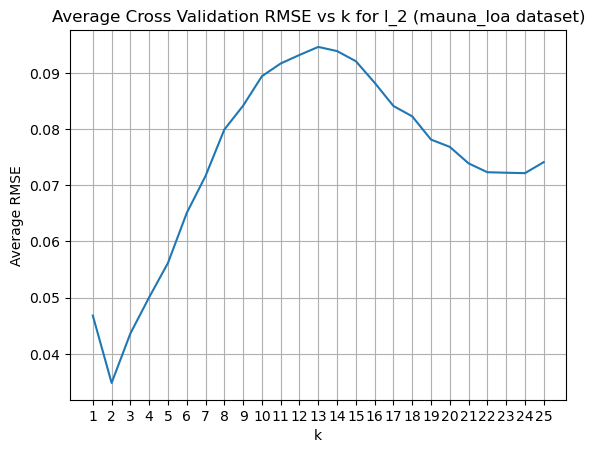

In [15]:
plt.figure()
plt.title("Average Cross Validation RMSE vs k for l_2 (mauna_loa dataset)")
plt.xlabel('k')
plt.ylabel('Average RMSE')
k_max = int(np.sqrt(x_train.shape[0]))
l = 2
x_axis = np.arange(k_max) + 1
y_axis = RMSE_avg[:,l-1]
plt.grid(visible=True)
plt.xticks(range(min(x_axis), max(x_axis)+1))
plt.plot(x_axis, y_axis)

We see k = 2 is the location of min RMSE. However, we also have k = 24 as a local min. Let's plot the regression model predictions for both k = 2 and k = 24 and compare with the actual test targets:

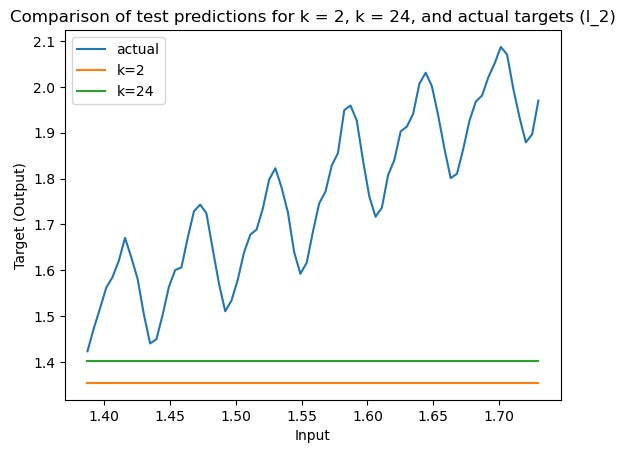

In [17]:
plt.figure()
plt.title("Comparison of test predictions for k = 2, k = 24, and actual targets (l_2)")
plt.xlabel("Input")
plt.ylabel("Target (Output)")
plt.plot(x_test, y_test, label='actual')
y_predict_k2 = kNN_regress(x_train, y_train, x_test, k=2, l=2)
y_predict_k24 = kNN_regress(x_train, y_train, x_test, k=24, l=2)
plt.plot(x_test, y_predict_k2, label="k=2")
plt.plot(x_test, y_predict_k24, label="k=24")
plt.legend(loc='best')


As we can see, the predictions for both k = 2 and k = 24 are not close at all, not even the behaviour of the data is captured. k = 24 is slightly closer to the actual targets.

Let's also plot the regression model for the training set:

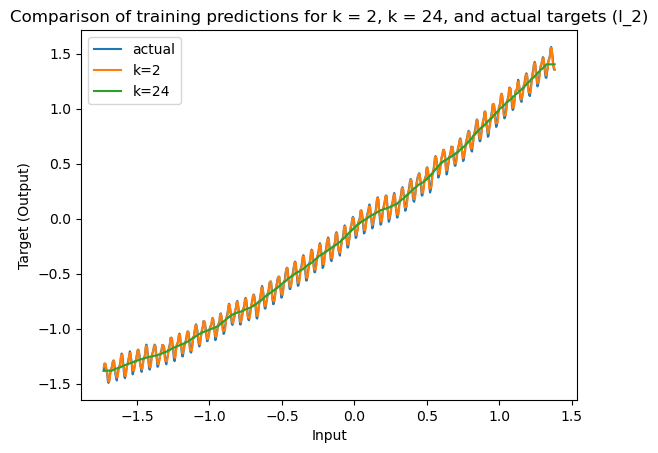

In [18]:
plt.figure()
plt.title("Comparison of training predictions for k = 2, k = 24, and actual targets (l_2)")
plt.xlabel("Input")
plt.ylabel("Target (Output)")
plt.plot(x_train, y_train, label='actual')
y_predict_k2 = kNN_regress(x_train, y_train, x_train, k=2, l=2)
y_predict_k24 = kNN_regress(x_train, y_train, x_train, k=24, l=2)
plt.plot(x_train, y_predict_k2, label="k=2")
plt.plot(x_train, y_predict_k24, label="k=24")
plt.legend(loc='best')